# Proyecto 2
## 1. Preparando los datos.
Los datos se descargan en [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [353]:
#Preparando las bibliotecas a utilizar
import sys

import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib as mpl
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
sys.path.append("../PythonCode")
from modelo import estadisticas
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [354]:
#Leyendo los datos a utilizar
data = pd.read_csv('../Datos/train.csv')
test_data = pd.read_csv('../Datos/test.csv')
test_data.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


Una vez leidos los datos se procede a dar un vistazo de
las variables que contiene. En este caso vemos que se trata de
una base de datos de **1460** registros y **80**
variables. Además se identifica la variable objetivo como **SalePrice**, por lo que quedan **79** variables
como posibles predictoras.



In [355]:
data.shape

(1460, 81)

In [356]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

De estas 79 variables hay algunas que en particular llaman mucho la atención, debido a la gran
cantidad de valores con NAN.
Estas son:

- Alley
- FireplaceQu
- PoolQC
- Fence
- MiscFeature

Estas deberán ser estudiadas a detalle antes de realizar los modelos.

Ahora vamos a separar las varibles según su tipo de dato. Vemos que los tres tipos presentes son:
- float64: variables continuas.
- int64: variables enteras (posiblemente son ordinales).
- object: variables cualitativas.

Se hace la unión de los datos de entrenamiento con los datos de test, esto debido a que se
hace más fácil manejarlo de esta manera.

In [357]:
print("El test",test_data.shape)
y = data.SalePrice
#data = data.drop("SalePrice", axis = 1)
data = pd.concat([data, test_data], keys=["train", "test"])
#print(data.loc["train"])


El test (1459, 80)


In [358]:
#data = data.drop('Id', axis=1)
test_data = test_data.drop('Id', axis=1)
continuas = []
enteras = []
object = []
for feature in data.columns:
    if str(data[feature].dtype) == "float64":
        continuas.append(feature)
    elif str(data[feature].dtype) == "int64":
        enteras.append(feature)
    elif str(data[feature].dtype) == "object":
        object.append(feature)

print(continuas)
print(enteras)
print(object)



['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice']
['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'Gar

En este caso las tres variables continuas se verifican como continuas, incluida *GarageYrBlt*.
Se clasifican las variables cualitativas en ordinales, nominales y dicotómicas.

In [359]:

continuas = continuas + ["LowQualFinSF",
                         "3SsnPorch","PoolArea","MiscVal","YrSold",
                         "FullBath","HalfBath","BedroomAbvGr",
           "KitchenAbvGr",
           "TotRmsAbvGrd",
                         ]

nominales = ["MSSubClass","MoSold",
             "MSZoning","Street","Alley","LotShape","LandContour",
             "Utilities", "LotConfig", "LandSlope", "Neighborhood",
             "Condition1", "Condition2","BldgType", "HouseStyle",
             "RoofStyle", "RoofMatl", "Exterior1st","Exterior2nd",
             "MasVnrType","Foundation","Heating", "Electrical",
             "Functional","GarageType","PavedDrive","Fence",
             "MiscFeature","SaleType","SaleCondition"
             ]
ordinal = ["OverallQual", "OverallCond",
           "Fireplaces",
           "ExterQual",
           "ExterCond",
           "BsmtQual",
           "BsmtCond",
           "BsmtExposure",
           "BsmtFinType2",
           "HeatingQC",
           "KitchenQual",
           "FireplaceQu",
           "GarageFinish",
           "GarageQual",
           "GarageCond",
           "PoolQC"]

dicotomicas = ["CentralAir",]
print(data.YearBuilt.nunique())
print(data.YearRemodAdd.nunique())
print(data.BsmtFinSF1.nunique())
print(data.BsmtFinSF2.nunique())

#Viendo por número de categorías
for x in  enteras:
    if data[x].nunique() < 50:
        print(x, data[x].nunique() )
print("********Object*********")
for x in  object:
    if data[x].nunique() < 50:
        print(x, data[x].nunique() )
print("********Features con 50 categorías o más*****")
for x in  enteras:
    if data[x].nunique() >= 50:
        print(x, data[x].nunique() )
        if x not in continuas:
            continuas.append(x)
            data[x] = pd.to_numeric(data[x])
continuas.remove("Id")
print("********Object*********")
for x in  object:
    if data[x].nunique() >= 50:
        print(x, data[x].nunique() )
        if x not in continuas:
            continuas.append(x)
#continuas.remove("SalePrice")

print("Continuas", len(continuas))
print("Dicotomicas", len(dicotomicas))
print("Nominales", len(nominales))
print("Ordinales", len(ordinal))
print("En total hay", len(continuas + dicotomicas + nominales + ordinal) , "features")

118
61
991
272
MSSubClass 16
OverallQual 10
OverallCond 9
LowQualFinSF 36
FullBath 5
HalfBath 3
BedroomAbvGr 8
KitchenAbvGr 4
TotRmsAbvGrd 14
Fireplaces 5
3SsnPorch 31
PoolArea 14
MiscVal 38
MoSold 12
YrSold 5
********Object*********
MSZoning 5
Street 2
Alley 2
LotShape 4
LandContour 4
Utilities 2
LotConfig 5
LandSlope 3
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 15
Exterior2nd 16
MasVnrType 4
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 4
BsmtCond 4
BsmtExposure 4
BsmtFinType1 6
BsmtFinType2 6
Heating 6
HeatingQC 5
CentralAir 2
Electrical 5
KitchenQual 4
Functional 7
FireplaceQu 5
GarageType 6
GarageFinish 3
GarageQual 5
GarageCond 5
PavedDrive 3
PoolQC 3
Fence 4
MiscFeature 4
SaleType 9
SaleCondition 6
********Features con 50 categorías o más*****
Id 2919
LotArea 1951
YearBuilt 118
YearRemodAdd 61
1stFlrSF 1083
2ndFlrSF 635
GrLivArea 1292
WoodDeckSF 379
OpenPorchSF 252
EnclosedPorch 183
ScreenPorch 121
********Object*********

Ahora se revisa los tipos de las variables para ver si son congruentes con su categorización.
Se convierten algunas variables enteras a cadena.

In [360]:
data[continuas].info()
data[dicotomicas].info()
data[nominales].info()
data[ordinal].info()

for x in nominales:
    if data[x].dtype != "object":
        data[x] = data[x].apply(str)

data["YearRemodAdd"] = data["YearRemodAdd"].apply(pd.to_numeric)
data["YrSold"] = data["YrSold"].apply(pd.to_numeric)

print("************Continuas")
data[continuas].info()
print("**********Dicotomicas")
data[dicotomicas].info()
print("**********Nominales")
data[nominales].info()
print("***********Ordinales")
data[ordinal].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, ('train', 0) to ('test', 1458)
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    2433 non-null   float64
 1   MasVnrArea     2896 non-null   float64
 2   BsmtFinSF1     2918 non-null   float64
 3   BsmtFinSF2     2918 non-null   float64
 4   BsmtUnfSF      2918 non-null   float64
 5   TotalBsmtSF    2918 non-null   float64
 6   BsmtFullBath   2917 non-null   float64
 7   BsmtHalfBath   2917 non-null   float64
 8   GarageYrBlt    2760 non-null   float64
 9   GarageCars     2918 non-null   float64
 10  GarageArea     2918 non-null   float64
 11  SalePrice      1460 non-null   float64
 12  LowQualFinSF   2919 non-null   int64  
 13  3SsnPorch      2919 non-null   int64  
 14  PoolArea       2919 non-null   int64  
 15  MiscVal        2919 non-null   int64  
 16  YrSold         2919 non-null   int64  
 17  FullBath       2919 non-null   

Revisando las variables en busca de NA para comprender mejor la situación. Para ello
primero vamos a calcular los porcentajes de NA en cada variable.

In [361]:
porcentajes = {}
for column in list(data.columns):
    porcentajes[column] = len(data[column][data[column].isna()==True]) / len(data[column]) *100
sorted(porcentajes.items(), key=lambda x:x[1])


[('Id', 0.0),
 ('MSSubClass', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('LotConfig', 0.0),
 ('LandSlope', 0.0),
 ('Neighborhood', 0.0),
 ('Condition1', 0.0),
 ('Condition2', 0.0),
 ('BldgType', 0.0),
 ('HouseStyle', 0.0),
 ('OverallQual', 0.0),
 ('OverallCond', 0.0),
 ('YearBuilt', 0.0),
 ('YearRemodAdd', 0.0),
 ('RoofStyle', 0.0),
 ('RoofMatl', 0.0),
 ('ExterQual', 0.0),
 ('ExterCond', 0.0),
 ('Foundation', 0.0),
 ('Heating', 0.0),
 ('HeatingQC', 0.0),
 ('CentralAir', 0.0),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', 0.0),
 ('GrLivArea', 0.0),
 ('FullBath', 0.0),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.0),
 ('KitchenAbvGr', 0.0),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', 0.0),
 ('PavedDrive', 0.0),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', 0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.0),
 ('PoolArea', 0.0),
 ('MiscVal', 0.0),
 ('MoSold', 0.0),
 ('YrSold', 0.0),
 ('SaleCondition', 0.0),
 ('Exterior1st', 0.

En este análisis se puede ver que hay columnas con 5.45% de datos con NAN y luego el número que les sigue es 16.65%
(LotFrontAge). Hacemos un análisis junto con el diccionario de variables y vemos que:
- LotFrontage: es una variable continua, al no haber dato no se puede inferir nada.
- FireplaceQu: es una variable ordinal. NA significa que la casa no tiene chimenea. En este caso esta variable podría ser
recodificada.
- Fence: Fence quality, variable ordinal. NA significa que la casa no tiene cerca. Al igual que el caso anterior la variable
podría ser recodificada.
- Alley: esta variable es nominal y el tipo de material del callejon. NA significa que la casa no tiene callejón aledaño.
La variable puede ser recodificada.
- MiscFeature: esta variable describe comodidades extras del hogar. El NA indica que la casa no tiene extras de lujo.
Esta variable también se podría recodificar.
- PoolQC: variable ordinal que describe la calidad de la piscina. NA se pone en caso la casa no tiene piscina. Esta variable
es candidata a ser recodificada.

Con esto, resulta conveniente graficar estas variables para ver su comportamiento.



(2919, 81)
['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'SalePrice']
Alley
FireplaceQu
PoolQC
Fence
MiscFeature


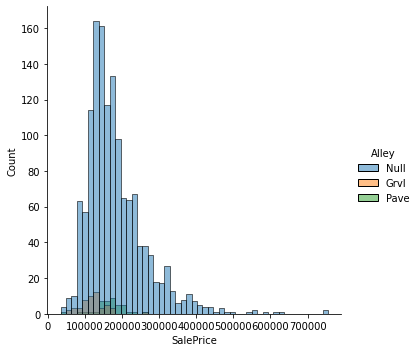

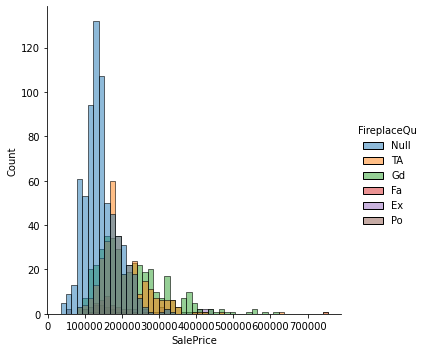

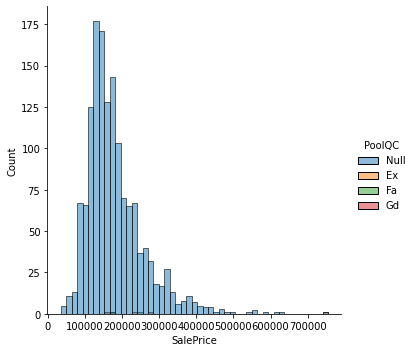

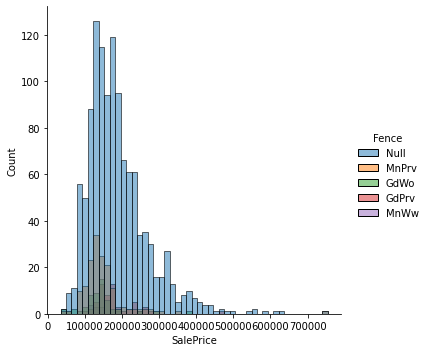

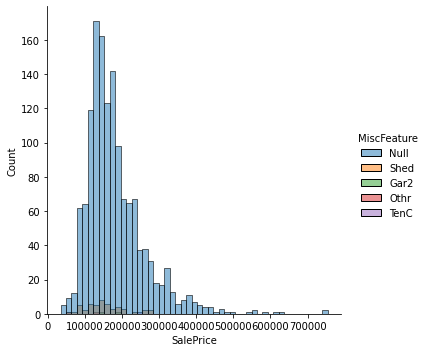

In [362]:
print(data.shape)
columnas_candidatas = []
for x in porcentajes:
    if porcentajes[x] >=10:
        columnas_candidatas.append(x)



columnas_candidatas = columnas_candidatas[1:]
print(columnas_candidatas)
training_recodificados = data.loc["train"].copy()
training_recodificados["SalePrice"] = y
columnas_candidatas.remove("SalePrice")
for col in columnas_candidatas:
    training_recodificados[col] = training_recodificados[col].fillna("Null")
    categorias = training_recodificados[col].value_counts().index.tolist()
    print(col)
    sb.displot(training_recodificados, x = "SalePrice", hue = col)



Vemos en las gráficas que en el caso de estas variables, el problema se arregla agregando una
categoría más en lugar del NA. Esto debido a que se trata de variables descriptoras de calidad, así que cuando
se encuentra un NA esto significa que la casa no tiene esa funcionalidad o ambiente, por lo que se
se consignará de esa manera. Esto también conlleva a que estas variables que antes habían sido catalogadas
como ordinales, ahora pasaran a ser variables nominales.


Histograma después de imputación
(2919, 81)


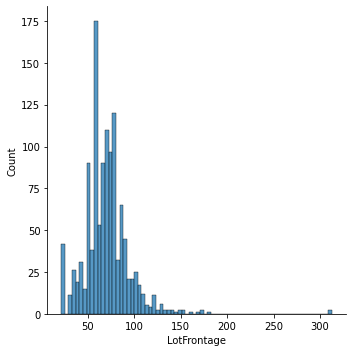

In [363]:

'''
training_recodificados.LotFrontage = np.where(data.LotFrontage.isnull(),1,0)
sb.displot(training_recodificados, x="SalePrice", hue="LotFrontage")
'''



imputer = SimpleImputer(missing_values= np.nan , strategy="mean")
imputer = imputer.fit(data[["LotFrontage"]])
data.LotFrontage = imputer.transform(data[["LotFrontage"]])
print("Histograma después de imputación")
sb.displot(training_recodificados, x = "LotFrontage")
print(data.shape)

Finalmente, se deben hacer imputaciones sobre el resto de las variables que tienen NANs y que no se pudieron arreglar
mediante recodificación. Notemos que algunas de ellas son numéricas y otras son categóricas. De esa cuenta, en el caso de las
numéricas, se imputarán usando como dato de imputación la media aritmética, mientras que para las categóricas se usará
como dato de imputación el dato más frecuente.



In [364]:
print(features_imputacion)
#Haciendo imputación

for x in features_imputacion:
    try:
        imputer = SimpleImputer(missing_values= np.nan , strategy="mean")
        imputer = imputer.fit(data[[x]])
        data[[x]] = imputer.transform(data[[x]])
    except:
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imp.fit(data[[x]])
        data[[x]] = imp.transform(data[[x]])
    else:
        print("Un error ha ocurrido mientras se imputaba", x)




['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']
Un error ha ocurrido mientras se imputaba MasVnrArea
Un error ha ocurrido mientras se imputaba BsmtFinSF1
Un error ha ocurrido mientras se imputaba BsmtFinSF2
Un error ha ocurrido mientras se imputaba BsmtUnfSF
Un error ha ocurrido mientras se imputaba TotalBsmtSF
Un error ha ocurrido mientras se imputaba BsmtFullBath
Un error ha ocurrido mientras se imputaba BsmtHalfBath
Un error ha ocurrido mientras se imputaba GarageYrBlt
Un error ha ocurrido mientras se imputaba GarageCars
Un error ha ocurrido mientras se imputaba GarageArea


In [365]:
print(data.shape)
data.FireplaceQu = data.FireplaceQu.fillna("NF")
data.Fence =data.Fence.fillna("NFe")
data.Alley = data.Alley.fillna("NoAlley")
data.MiscFeature = data.MiscFeature.fillna("NoMiscFeature")
data.PoolQC = data.PoolQC.fillna("NoP")

print(data.shape)

(2919, 81)
(2919, 81)


Ahora se atienden las variables que tienen bajo porcentaje de NANs, haciendo imputaciones para el resto de las variables (cuyos porcentajes de NA fueron
menor a 10%).

In [366]:
features_imputacion = []
for x in porcentajes:
    if porcentajes[x] <10 and porcentajes[x] >0:
        features_imputacion.append(x)
        print(x, porcentajes[x])
print(features_imputacion)

data.MasVnrType = data.MasVnrType.fillna("NoMasonry")
data.MasVnrArea =data.MasVnrArea.fillna(0)
data.BsmtQual = data.BsmtQual.fillna("NB") #Cambiar a nominal
data.BsmtCond = data.BsmtCond.fillna("NB") #Cambiar a nominal
data.BsmtExposure = data.BsmtExposure.fillna("NB") #Cambiar a nominales
data.BsmtFinType1 = data.BsmtFinType1.fillna("NB") #Cambiar a nominales
data.BsmtFinType2 = data.BsmtFinType2.fillna("NB") #Cambiar a nominal
#Con electrical el dato si está perdido, se sugiere perder esos registros
data.GarageType = data.GarageType.fillna("NG")
#Imputación
imputer = SimpleImputer(missing_values= np.nan , strategy="mean")
imputer = imputer.fit(data[["GarageYrBlt"]])
data.GarageYrBlt = imputer.transform(data[["GarageYrBlt"]])
#***
data.GarageFinish = data.GarageFinish.fillna("NG") #Cambiar a nominal si necesario
data.GarageQual = data.GarageQual.fillna("NG") #Cambiar a nominales
data.GarageCond = data.GarageCond.fillna("NG") #Cambiar a nominal



porcentajes = {}
for column in list(data.columns):
    porcentajes[column] = len(data[column][data[column].isna()==True]) / len(data[column]) *100
print(sorted(porcentajes.items(), key=lambda x:x[1]))
drop = []
print("Porcentaje vale", porcentajes)
for x in porcentajes.keys():
    if porcentajes[x] >0 and x!="SalePrice":
        drop.append(x)
        data.loc["train"].dropna( subset=[x] , inplace=True)
        print(x)
        print(data.shape)



MSZoning 0.1370332305584104
Utilities 0.0685166152792052
Exterior1st 0.0342583076396026
Exterior2nd 0.0342583076396026
MasVnrType 0.8221993833504625
MasVnrArea 0.7879410757108599
BsmtQual 2.774922918807811
BsmtCond 2.8091812264474134
BsmtExposure 2.8091812264474134
BsmtFinType1 2.7064063035286057
BsmtFinSF1 0.0342583076396026
BsmtFinType2 2.7406646111682083
BsmtFinSF2 0.0342583076396026
BsmtUnfSF 0.0342583076396026
TotalBsmtSF 0.0342583076396026
Electrical 0.0342583076396026
BsmtFullBath 0.0685166152792052
BsmtHalfBath 0.0685166152792052
KitchenQual 0.0342583076396026
Functional 0.0685166152792052
GarageType 5.378554299417608
GarageYrBlt 5.4470709146968135
GarageFinish 5.4470709146968135
GarageCars 0.0342583076396026
GarageArea 0.0342583076396026
GarageQual 5.4470709146968135
GarageCond 5.4470709146968135
SaleType 0.0342583076396026
['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', '

In [367]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, ('train', 0) to ('test', 1458)
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   object 
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   

## 2. Explorando los datos
En esta parte se hará una exploración de los datos para ganar un poco de intuición a cerca de
como se comportan las variables.


In [368]:
data.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,2007.792737,180921.195890
std,842.787043,21.312345,7886.996359,1.409947,1.113131,30.291442,20.894344,178.626089,455.532750,169.176615,...,215.357904,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,1.314964,79442.502883
min,1.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.000000,34900.000000
25%,730.500000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,129975.000000
50%,1460.000000,69.305795,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,369.000000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,163000.000000
75%,2189.500000,78.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,214000.000000
max,2919.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,2010.000000,755000.000000


In [369]:
print(data.shape)

target = data.loc["train"].copy()
target["SalePrice"] = y
#target = target.drop(['SalePrice'], axis=1)

(2919, 81)


Construyendo histogramas para las variables numéricas para ver su comportamiento

/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


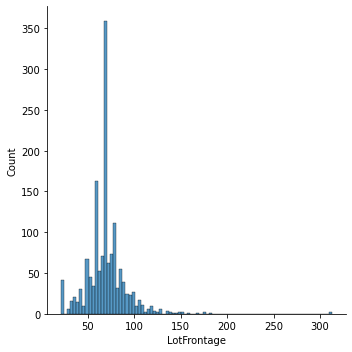

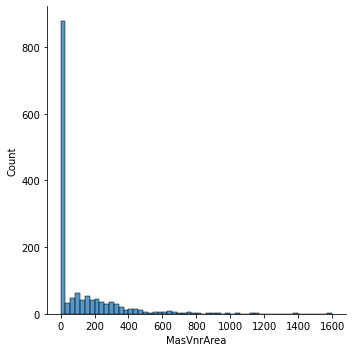

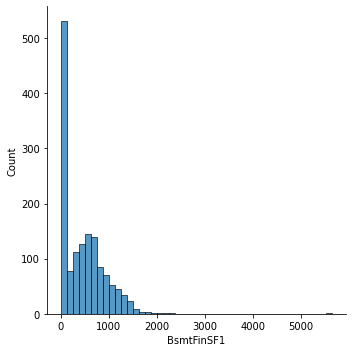

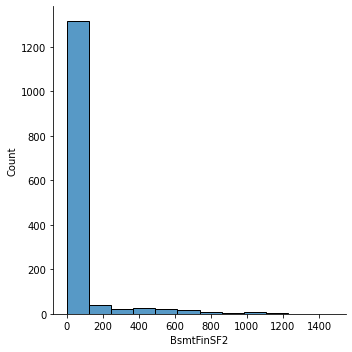

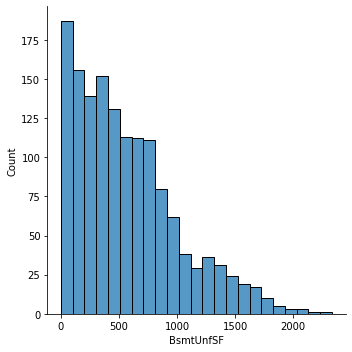

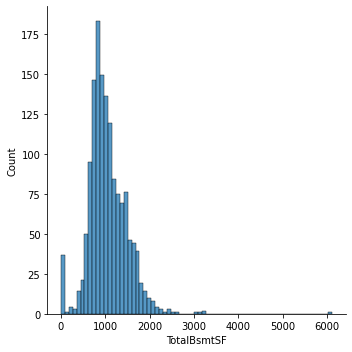

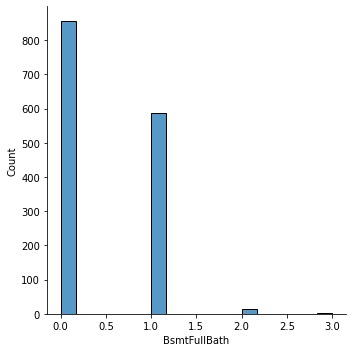

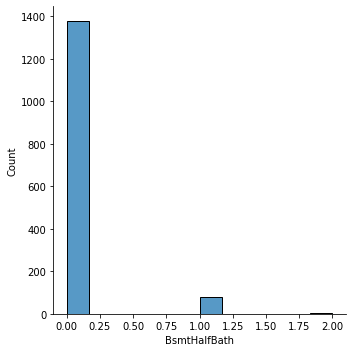

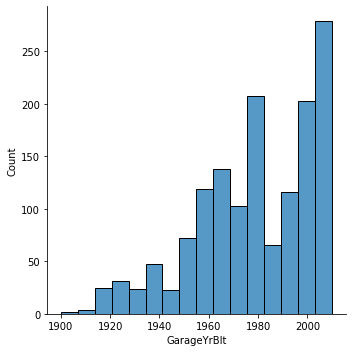

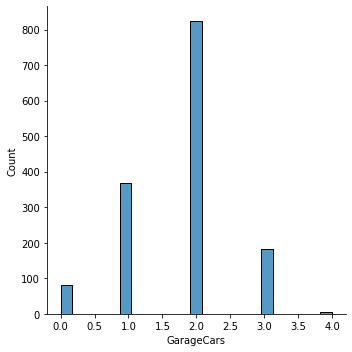

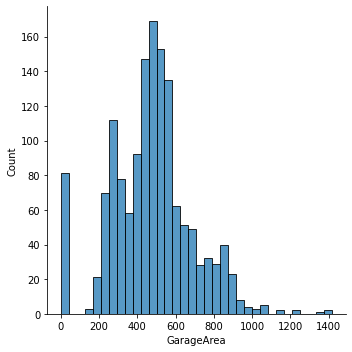

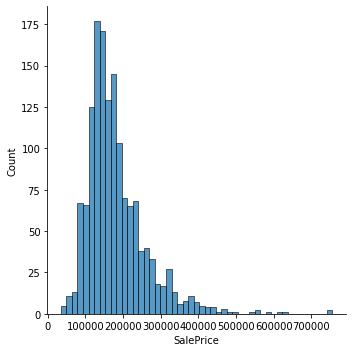

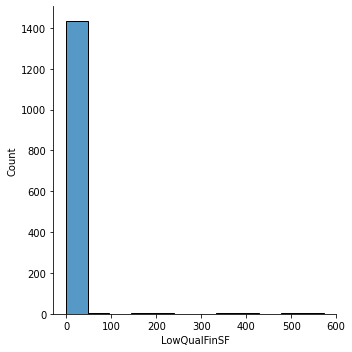

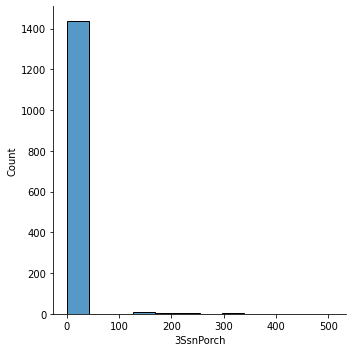

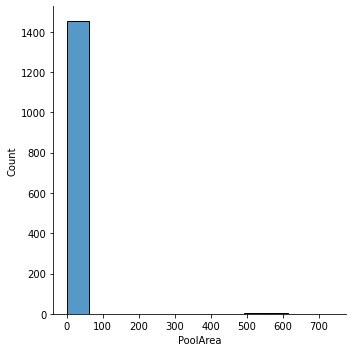

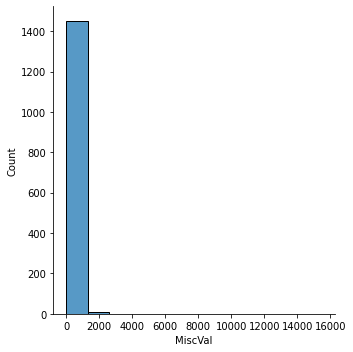

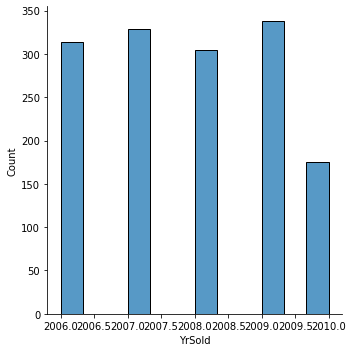

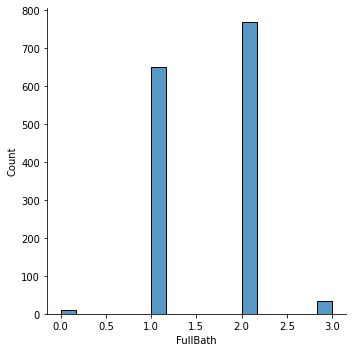

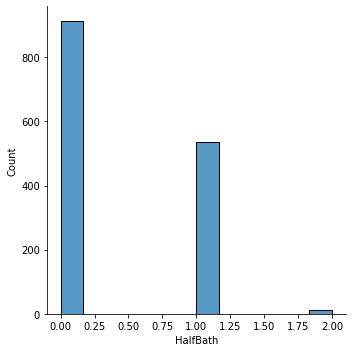

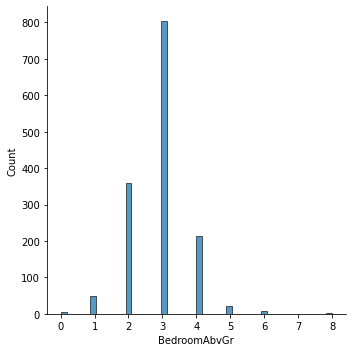

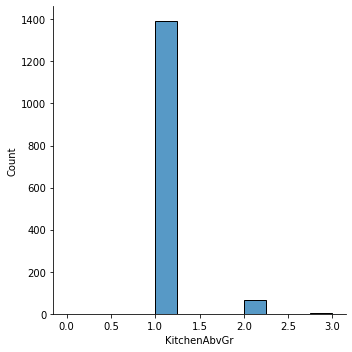

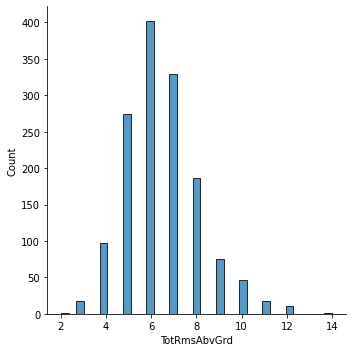

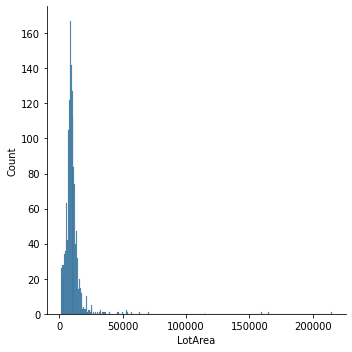

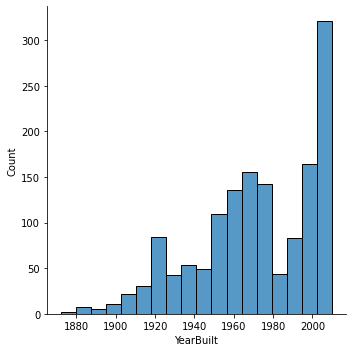

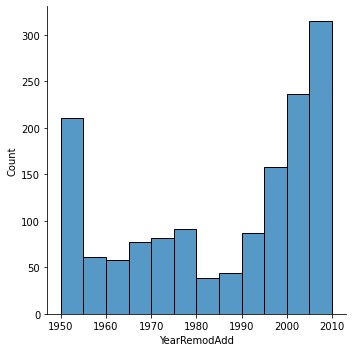

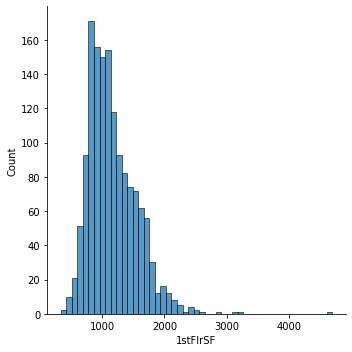

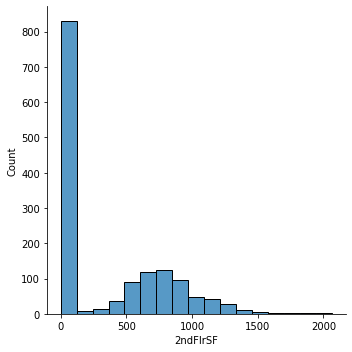

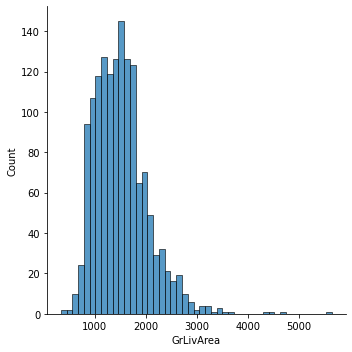

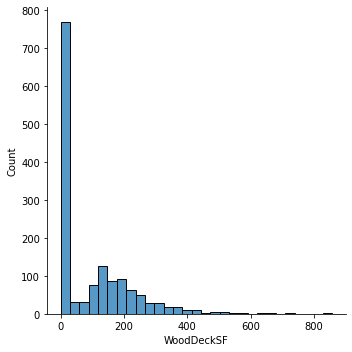

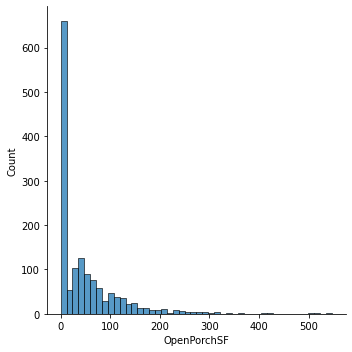

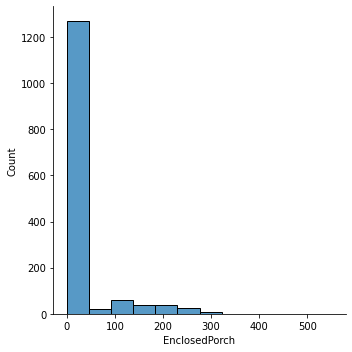

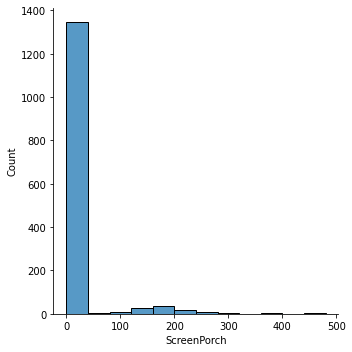

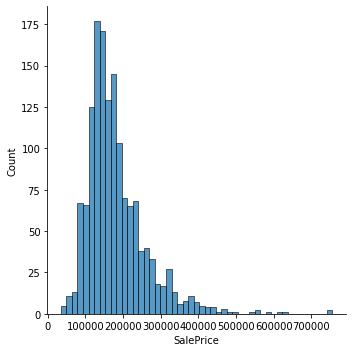

In [370]:
for x in continuas:
    sb.displot(target, x = x)
sb.displot(target, x = y)

Se puede apreciar gráficas en donde se distribuyen muy bien los datos y otras donde no tanto.
En particular, se observa que la distribución de la variable objetivo (SalePrice) no se distribuye normalmente,
por lo que se deberá aplicar una transformación a la misma (sería ideal hacer una prueba de hipótesis primero).
Ahora veremos como se comportan las variables numéricas respecto a la variable objetivo.

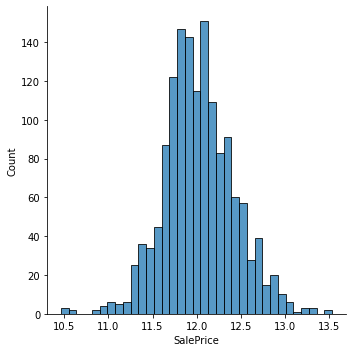

In [371]:
y = np.log(target["SalePrice"])
sb.displot(target, x = y)
#data["SalePrice"] = y

['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice', 'LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal', 'YrSold', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'LotArea', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


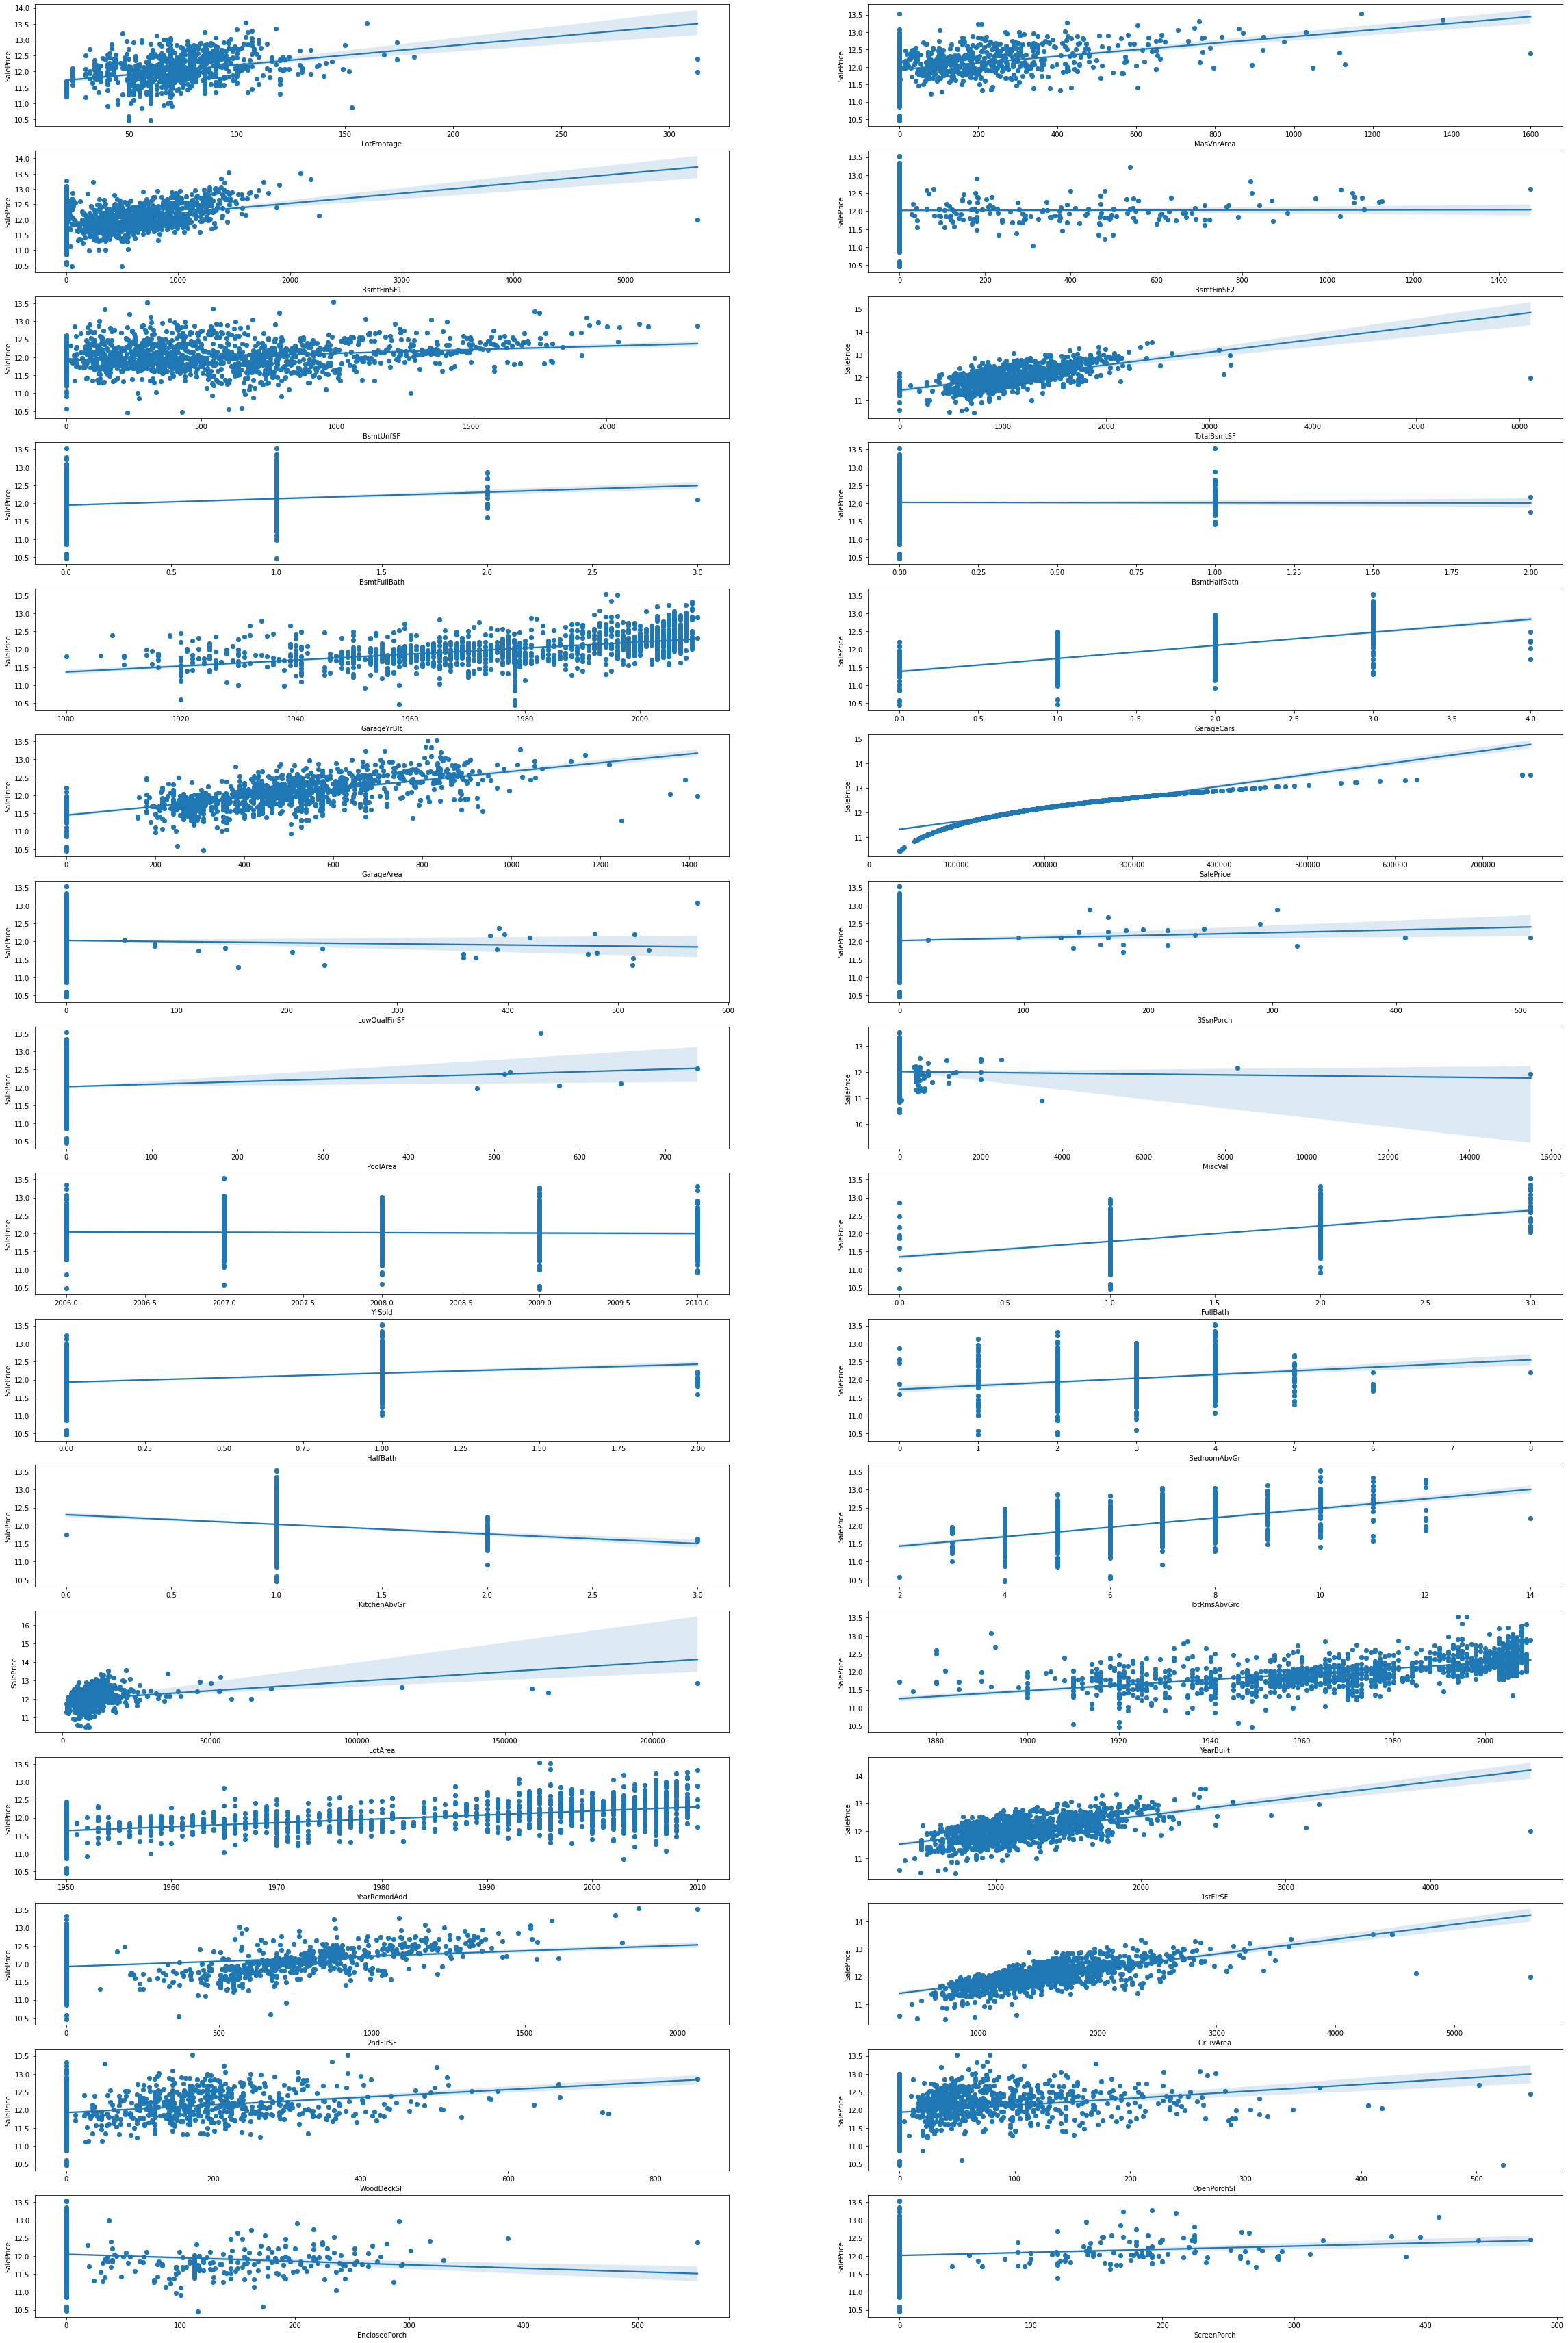

In [372]:
c = 1
fig = mpl.pyplot.figure(figsize=(40,70))
print(continuas)
for feature in continuas:
    mpl.pyplot.subplot(18,2,c)
    mpl.pyplot.xlabel(feature)
    mpl.pyplot.ylabel('SalePrice')
    sb.regplot(x = target[feature], y=y)
    mpl.pyplot.scatter(target[feature], y ,label = feature)
    c = c + 1

Con estas gráficas vemos que casi todas las variables numéricas parecen ser buenas predictoras, salvo:
- BsmtFinSF2
- YrSold
- PoolArea



Ahora vemos comos lucen las variables categóricas.

MSSubClass
MoSold
MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Foundation
Heating
Electrical
Functional
GarageType


/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


PavedDrive
Fence
MiscFeature
SaleType
SaleCondition
OverallQual
OverallCond
Fireplaces
ExterQual
ExterCond
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType2
HeatingQC
KitchenQual
FireplaceQu
GarageFinish
GarageQual
GarageCond
PoolQC


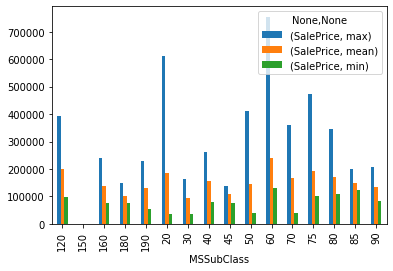

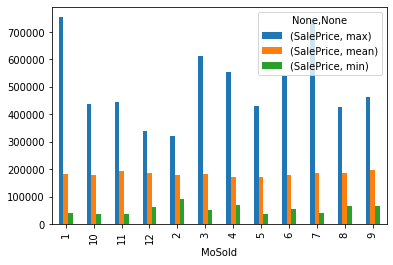

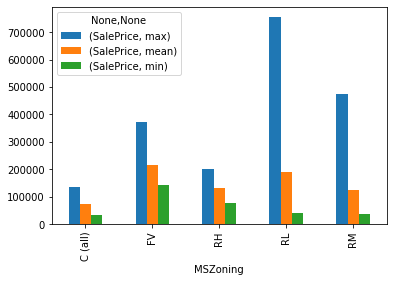

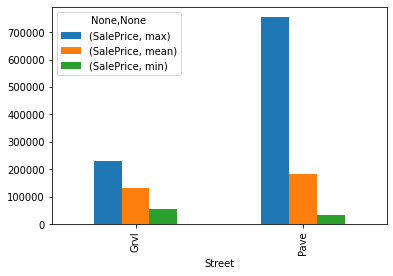

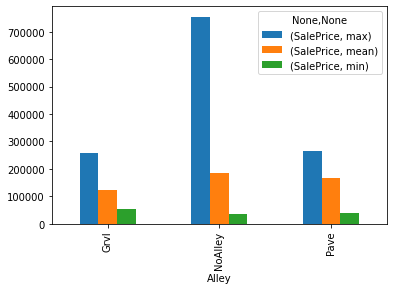

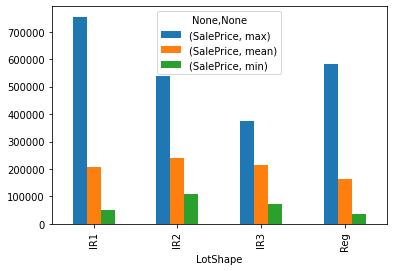

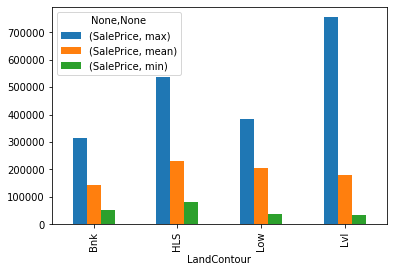

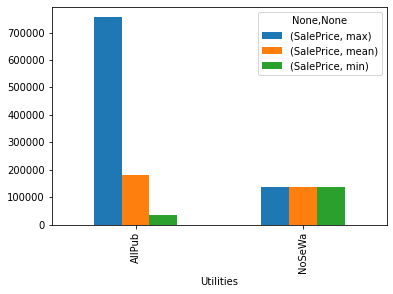

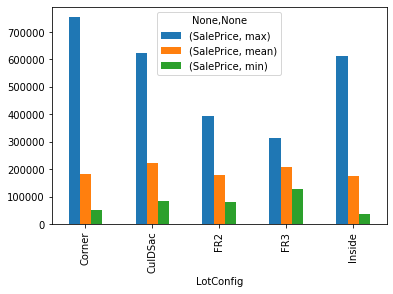

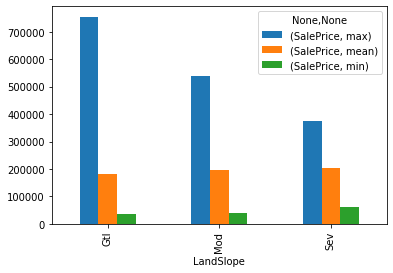

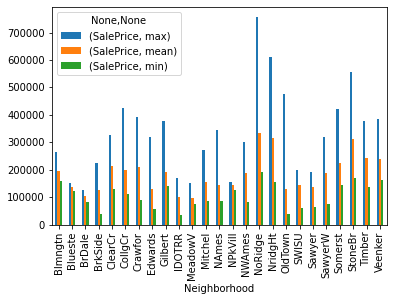

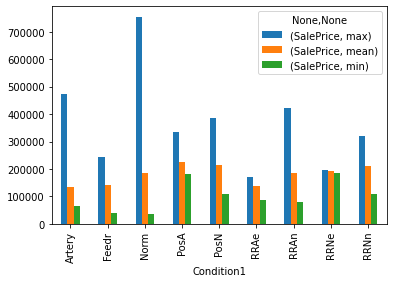

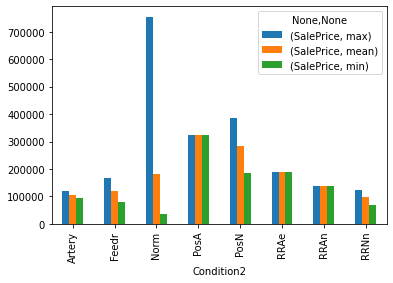

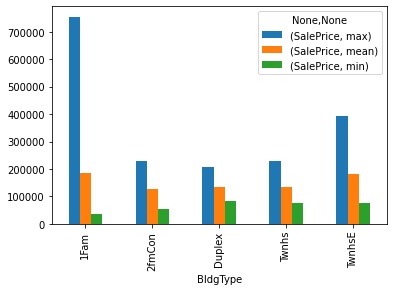

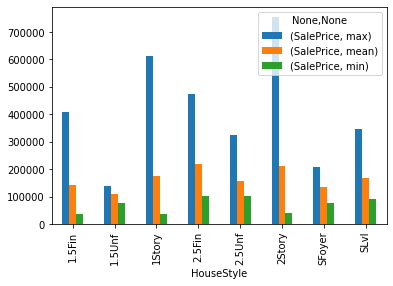

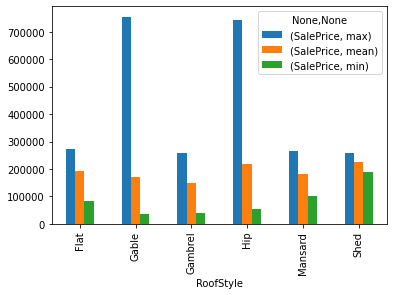

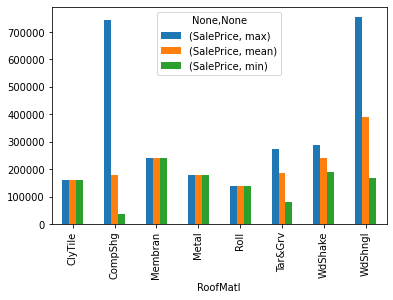

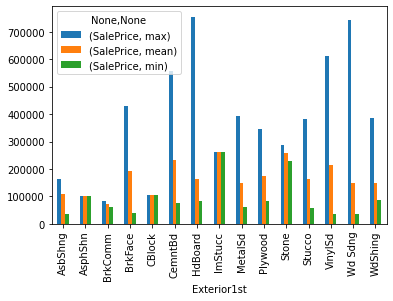

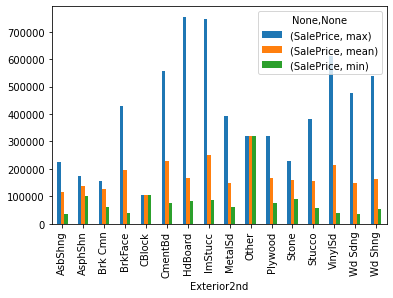

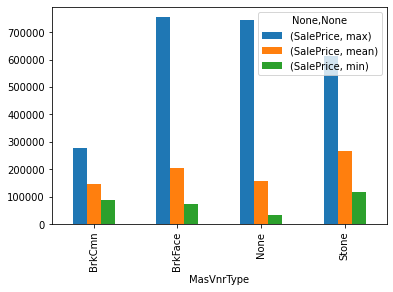

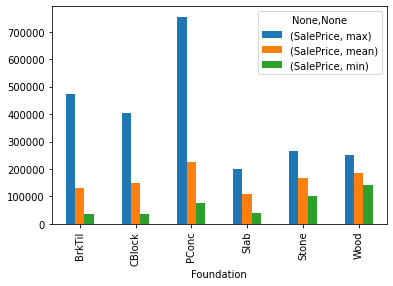

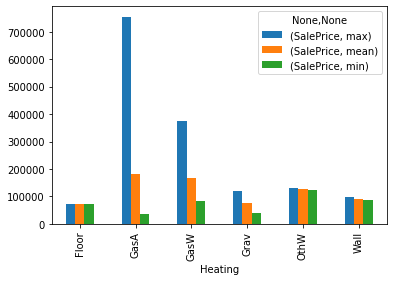

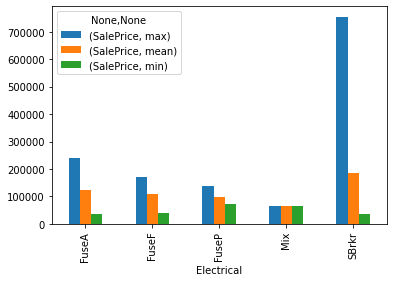

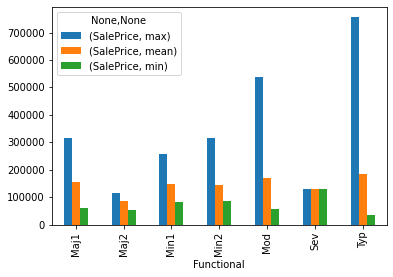

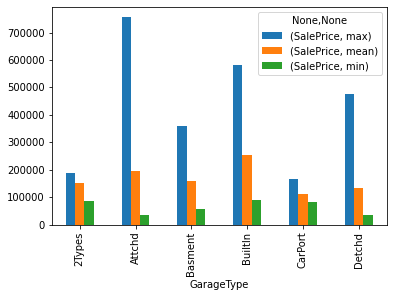

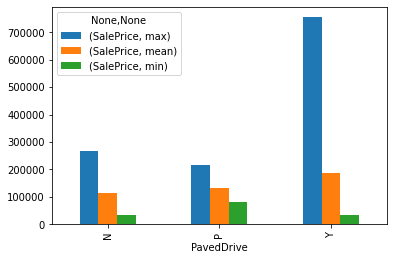

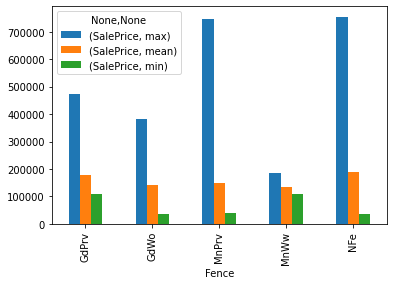

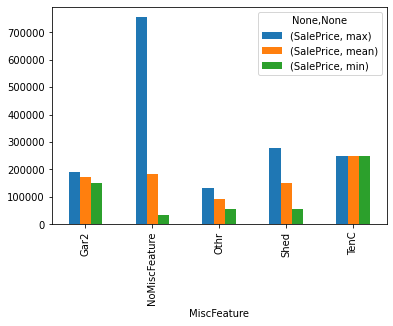

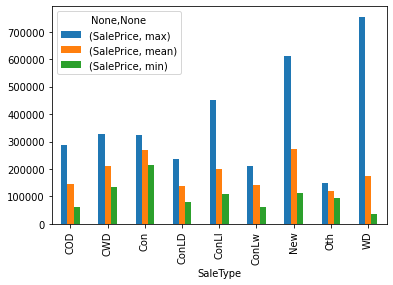

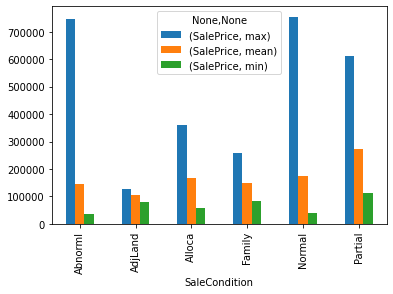

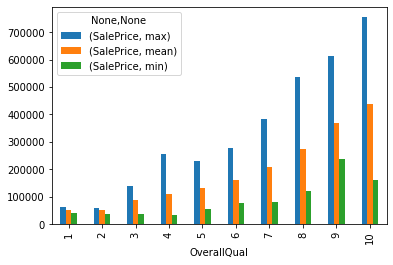

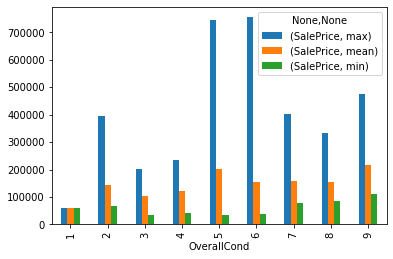

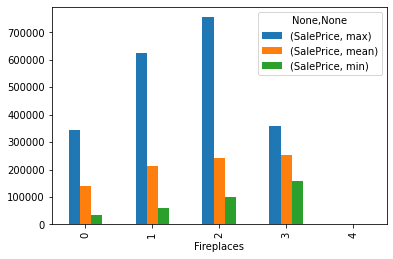

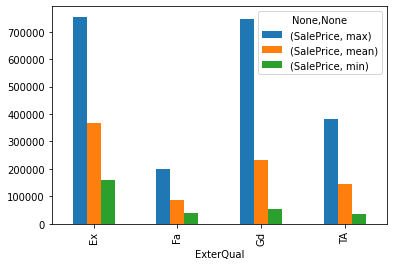

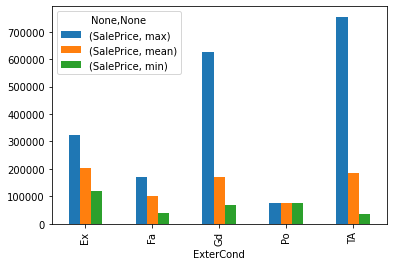

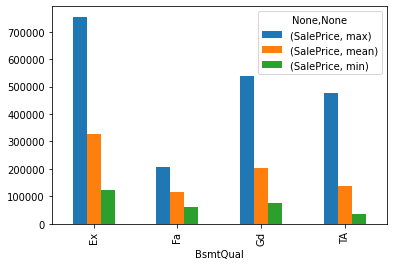

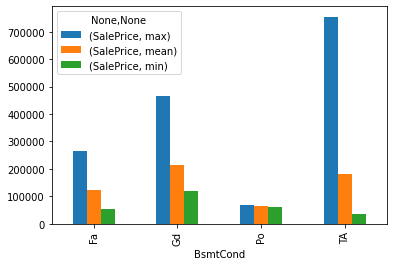

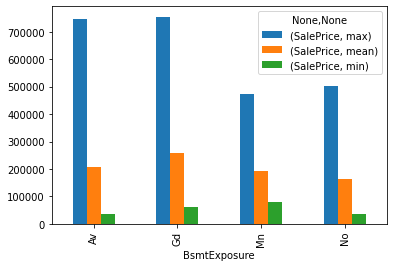

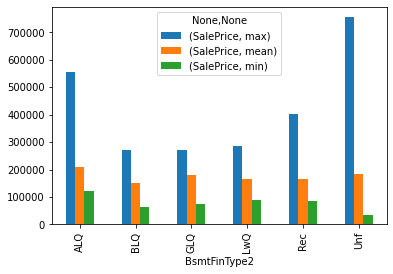

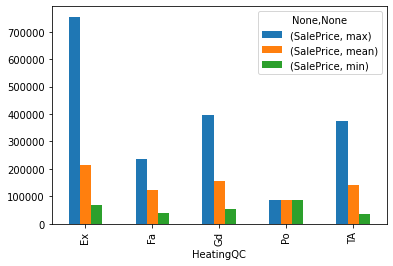

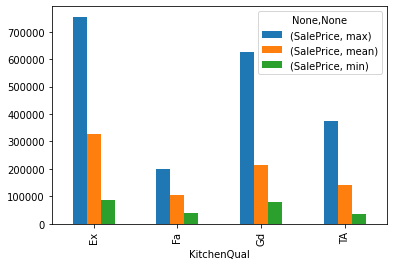

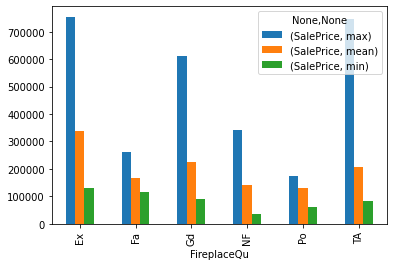

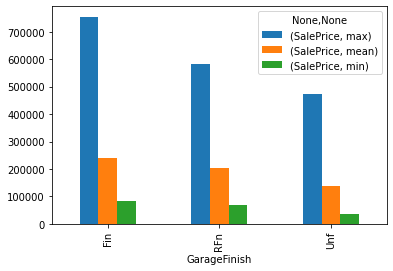

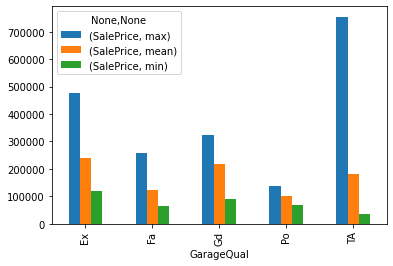

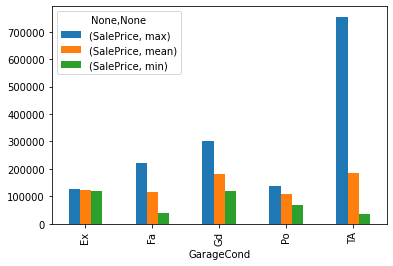

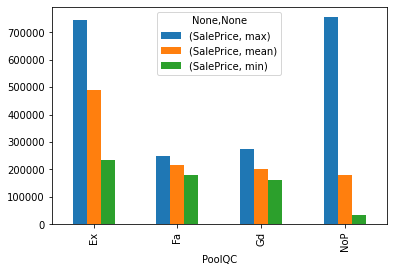

In [373]:
for feature in nominales:
    print(feature)
    data[[str(feature),'SalePrice']].groupby(feature).agg({'mean','max','min'}).plot.bar()
for feature in ordinal:
    print(feature)
    data[[str(feature),'SalePrice']].groupby(feature).agg({'mean','max','min'}).plot.bar()


De acá vemos, que además de que la variable MoSold ya tenía poco sentido, parace no tener mayor relación con el modelo
ya que no se ve diferencias significativas entre las distintas categorías. Esta variable es candidata a ser removida del modelo.


In [374]:
print(continuas)
correlaciones = target[continuas].corr()
correlaciones.shape

['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice', 'LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal', 'YrSold', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'LotArea', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


(32, 32)

Como es era esperado, la matriz de correlaciones es de 23x23. 
Como resulta díficil visualizar la matriz de correlaciones se construye una visualización utilizando la biblioteca
seaborn.

<AxesSubplot:>

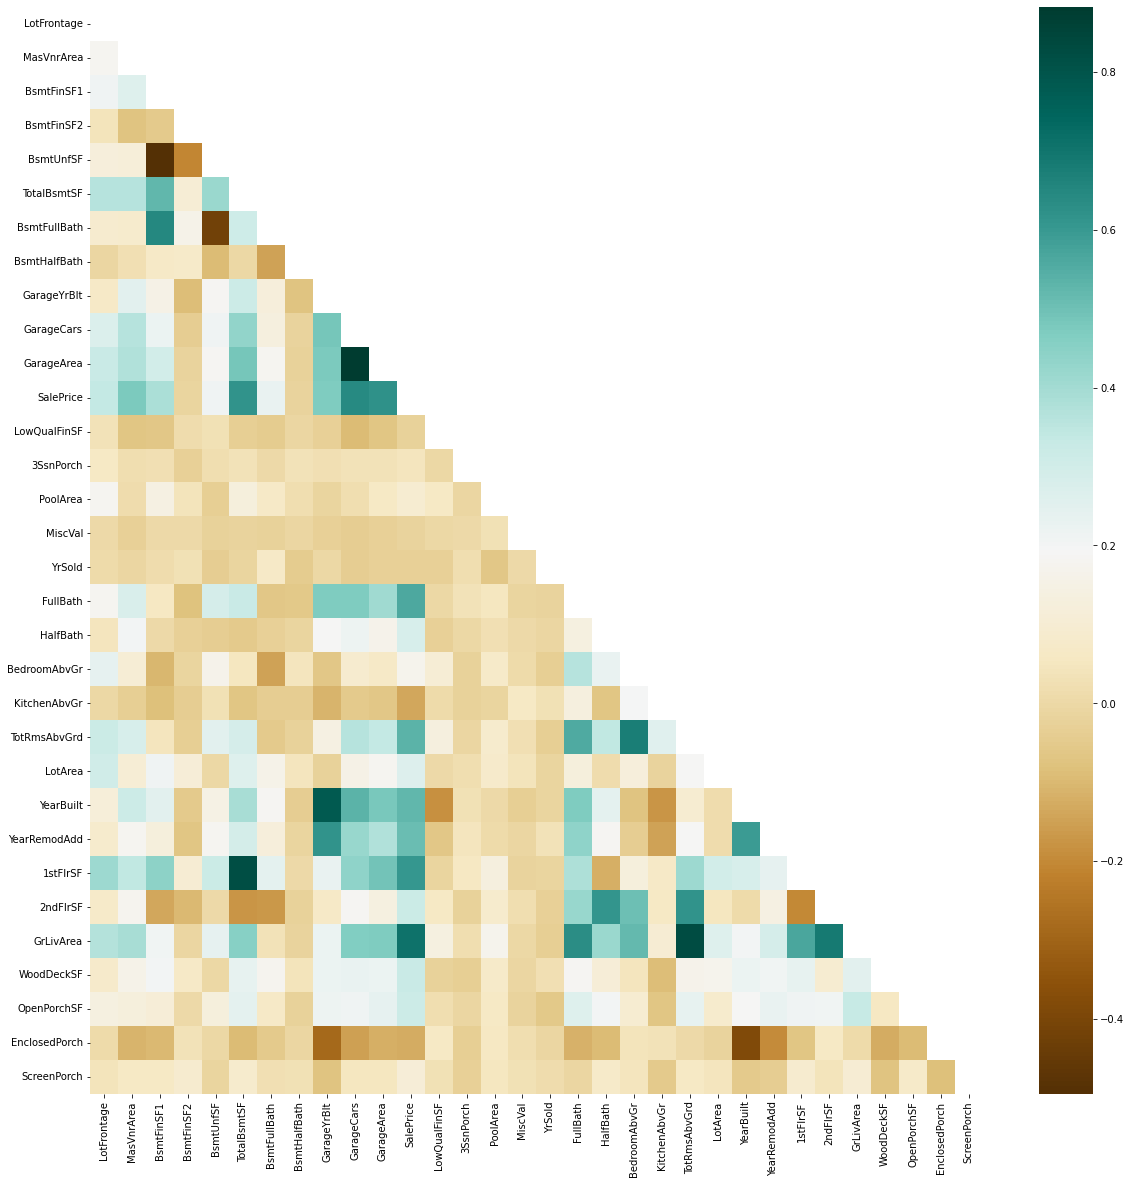

In [375]:
mask = np.triu(np.ones_like(correlaciones, dtype="bool"))
_, ax = mpl.pyplot.subplots(figsize=(20,20))
sb.heatmap(correlaciones, mask=mask, cmap='BrBG', ax = ax)

Se observan variables fuertemente correlacionadas.
Con correlación positiva:
- YearBuilt y GarageYrBlt y YearRemodAdd
- YearRemodAdd y YearBuilt
- 1stFlrSF1 y TotalBsmtSF: Total square feet of basement area

Con correlación negativa:

- BsmtUnfSF y BsmTFinSF1
- EnclosedPorch y GarageYrBlt
- EnclosedPorch y YearBuilt

## 3. Preparación de datos finales
En esta parte agregamos las variables dummies y se separan los datos en datos de entrenamiento y datos de validación.



In [376]:
print(data.shape)
enc = OrdinalEncoder()
enc.fit(data[ordinal])
data[ordinal] = enc.transform(data[ordinal])

(2919, 81)


In [377]:
final_features =continuas + dicotomicas + nominales + ordinal
final_data = data[final_features]
print(final_data.shape)


(2919, 79)


In [378]:
X_dummies = pd.get_dummies(final_data)
X = X_dummies.loc["train"]
print(X.shape)
X.drop("SalePrice", axis=1, inplace=True)
print(X.shape)
#X_dummies.loc["test"].info()

(1460, 268)
(1460, 267)


/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [379]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y,test_size=0.2, random_state=5)


## 4. Modelos propuestos
Ahora haremos una regresión lineal normal utilizando las 269 variables (incluidas las dummies). Cabe destacar que, siguiendo
los lineamientos de Gerón, usaremos como medida del desempeño el RSME. En la literatura se acostumbra decir que con un RSME
<=0.5 se considera que el modelo tiene buena capacidad de predicción y entre más pequeño sea el RSME mejor es el modelo.

In [380]:
from math import exp
import statsmodels.api as sm
reg = LinearRegression()
reg.fit(X_train, y_train)

print("**********Estadísticas training********")
y_predicted = reg.predict(X_train)
estadisticas(y_predicted,y_train)

print("*******Estadísticas testeo*****")
y_predicted = reg.predict(X_holdout)
estadisticas(y_predicted,y_holdout)

**********Estadísticas training********
R-Square Value 0.9439162737192711


mean_absolute_error : 0.06549455740507339


mean_squared_error :  0.008817315954081558


root_mean_squared_error :  0.09390056418404288
*******Estadísticas testeo*****
R-Square Value -308504.2356959959


mean_absolute_error : 17.520054942404062


mean_squared_error :  51925.77000896375


root_mean_squared_error :  227.8722668710779


In [381]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train,X2)
est2 = est.fit()


Con esto vemos que el modelo se sobreentrena, ya que en la parte de entrenamiento logra buen ajuste (R2=0.944) y buen
RSME (0.09), pero cuando hacemos la validación con los datos de validación, vemos que el ajuste se pierde (R2=-308404)
y RSME demasiado alto (227.9). Esto nos está diciendo que este modelo es malo prediciendo, y sacar el promedio de los datos
sería un mejor modelo que esta regresión.





Debido a que se está observando un sobreentrenamiento (posiblemente al gran número de variables), se hace necesario
recurrir a la regularización. Haremos la prueba primero con la regularización de Ridge.
Para ello probaremos con valores de alfa muy pequeños y otros más grandes (hasta 100) y comparamos los resultados del
RSME.

In [382]:
from sklearn.preprocessing import StandardScaler
alpha_ridge = [0,1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20,100]
for i in range(len(alpha_ridge)):
    print("*************Alpha = %.2e******************"%alpha_ridge[i])
    ridgereg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=alpha_ridge[i]))
    ridgereg.fit(X_train,y_train)
    print("**********Estadísticas training Alpha = %.2e******************"%alpha_ridge[i])
    y_predicted = ridgereg.predict(X_train)
    estadisticas(y_predicted,y_train)

    print("*******Estadísticas testeo Alpha = %.2e******************"%alpha_ridge[i])
    y_predicted = ridgereg.predict(X_holdout)
    estadisticas(y_predicted,y_holdout)
from IPython.display import Image

*************Alpha = 0.00e+00******************
**********Estadísticas training Alpha = 0.00e+00******************
R-Square Value 0.8567693477066085


mean_absolute_error : 0.1166799253319561


mean_squared_error :  0.022518295401031178


root_mean_squared_error :  0.15006097227804163
*******Estadísticas testeo Alpha = 0.00e+00******************
R-Square Value -3.9906151164084527e+27


mean_absolute_error : 1560133866566.9604


mean_squared_error :  6.716766484090138e+26


root_mean_squared_error :  25916725263987.613
*************Alpha = 1.00e-15******************
**********Estadísticas training Alpha = 1.00e-15******************
R-Square Value 0.9439182710593352


mean_absolute_error : 0.06549574390970525


mean_squared_error :  0.00881700193824165


root_mean_squared_error :  0.09389889210337708
*******Estadísticas testeo Alpha = 1.00e-15******************
R-Square Value -3.7369938665644096


mean_absolute_error : 0.14751885054209732


mean_squared_error :  0.7973026891883245


root

Acá, vemos que el mejor RSME (0.1245) se obtiene con alfa = 100. Hacemos la predicción para los datos de testeo con este modelo
y lo subimos al Kaggle. Vemos que obtiene un RSME de 0.14481

<img alt="Resultados en Kaggle" src="/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/Imagenes/Ridgealfa100.png" title="Ridge con Alfa 100"/>

In [383]:
test = X_dummies.loc["test"]
test.drop("SalePrice",axis=1, inplace=True)
y_predicted = ridgereg.predict(test)
y_predicted = np.exp(y_predicted)
Id=pd.read_csv('../Datos/test.csv').Id
salida = pd.DataFrame(y_predicted,Id.tolist())
salida.to_csv('../Datos/salida.csv', index=True)


/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Con Ridge Cross Validation (RidgeCV), podemos automatizar el proceso de encontrar el mejor alfa, en este caso lo buscamos
con rangos entre 10^-2 y 10^3. Al utilizar el alfa que optimiza corremos la predicción con los datos de test, pero
al subirlo a Kaggle, el puntaje no mejora.

In [384]:
alpha_range = 10.**np.arange(-2, 3)
ridgereg = make_pipeline(StandardScaler(with_mean=False), RidgeCV(alphas=alpha_range,scoring='neg_mean_squared_error'))
ridgereg.fit(X_train,y_train)
print("**********Estadísticas training RidgeCV******************")
y_predicted = ridgereg.predict(X_train)
estadisticas(y_predicted,y_train)

print("*******Estadísticas testeo RidgeCV******************")
y_predicted = ridgereg.predict(X_holdout)
estadisticas(y_predicted,y_holdout)


**********Estadísticas training RidgeCV******************
R-Square Value 0.9414348555977072


mean_absolute_error : 0.06750905576562512


mean_squared_error :  0.009207437100499215


root_mean_squared_error :  0.09595539120080339
*******Estadísticas testeo RidgeCV******************
R-Square Value 0.9077834704750518


mean_absolute_error : 0.08455365962958113


mean_squared_error :  0.01552133885940213


root_mean_squared_error :  0.12458466542637633


In [385]:
test = X_dummies.loc["test"]
test.drop("SalePrice",axis=1, inplace=True)
y_predicted = ridgereg.predict(test)
y_predicted = np.exp(y_predicted)
Id=pd.read_csv('../Datos/test.csv').Id
salida = pd.DataFrame(y_predicted,Id.tolist())
print(salida)
salida.to_csv('../Datos/salida_RidgeCV.csv', index=True)

                  0
1461  124117.840737
1462  118786.923146
1463  181346.566044
1464  201528.276367
1465  191117.112345
...             ...
2915   84687.549599
2916   80734.269344
2917  169613.050229
2918  110683.687406
2919  226770.975831

[1459 rows x 1 columns]


/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Finalmente, probamos suerte con regularización de Lasso, utilizando LassoCV para encontrar el mejor parámetro para alpha.
En este caso es alpha = 0.0001776256891830261.
Corremos el modelo con este parámetro y subimos los datos al Kaggle. El puntaje RSME mejora, aunque no significativamente,
el mismo se ubica en 0.14165.

![Salida con Lasso](/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/Imagenes/Lasso.png "Lasso")



In [386]:
lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassoregcv.fit(X_train, y_train)
print('alpha : ',lassoregcv.alpha_)

print("**********Estadísticas training LassoCV******************")
y_predicted = lassoregcv.predict(X_train)
estadisticas(y_predicted,y_train)

print("*******Estadísticas testeo LassoCV******************")
y_predicted = lassoregcv.predict(X_holdout)
estadisticas(y_predicted,y_holdout)




alpha :  0.0001776256891830261
**********Estadísticas training LassoCV******************
R-Square Value 0.9262244369738492


mean_absolute_error : 0.07535574219992669


mean_squared_error :  0.011598773691243675


root_mean_squared_error :  0.10769760299674118
*******Estadísticas testeo LassoCV******************
R-Square Value 0.9164912230235194


mean_absolute_error : 0.07989199364955359


mean_squared_error :  0.014055701638994462


root_mean_squared_error :  0.11855674438425873


/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [387]:
test = X_dummies.loc["test"]
test.drop("SalePrice",axis=1, inplace=True)
y_predicted = lassoregcv.predict(test)
y_predicted = np.exp(y_predicted)
Id=pd.read_csv('../Datos/test.csv').Id
salida = pd.DataFrame(y_predicted,Id.tolist())
print(salida)
salida.to_csv('../Datos/salida_LassoCV.csv', index=True)

                  0
1461  123072.210011
1462  154171.888269
1463  176272.231306
1464  193615.612475
1465  196731.871988
...             ...
2915   87445.728624
2916   88112.488746
2917  169032.770636
2918  118378.722318
2919  234475.091769

[1459 rows x 1 columns]


/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 5. Conclusiones
1. Es importante hacer una buena exploración de los datos antes de comenzar con los modelos. Conocer los datos permitirá
comprender de mejor manera el problema y abordarlo con las herramientas adecuadas.
2. La regresión lineal múltiple utilizando todos los parámetros produce un sobreentrenamiento, arrojando un modelo que es peor
que si solo utilizaramos el promedio como predictor.
3. Al utilizar regularización de Ridge, se logra relajar la función de error, lo que permite tener un modelo más flexible.
También es importante conocer la herramienta RidgeCV para encontrar de forma automatizada mejores parámetros de penalización.
4. La regularización de Lasso tiene la bondad de "eliminar" algunas variables que no son significativas en el modelo (pone
coeficientes cero). En esta parte sería importante analizar que variables está quitando para ver si concuerdan con la intuición
construida en la parte exploratoria.
5. Es importante continuar mejorando el modelo y en su momento utilizar las técnicas que originalmente proponia el ejercicio,
esto es **random forest** y **gradient boosting**.

## 6. Referencias
1. Gerón, Aurilien. Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow. O'Reilly Media. 2019.
2. Gareth, James; Witte, Daniela; Hastie, Trevor y Tibshirani, Robert. An Introduction to Statistical Learning. Second Edition.
3. https://towardsdatascience.com/super-simple-machine-learning-by-me-multiple-linear-regression-part-1-447800e8b624
4. https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d
5. https://www.youtube.com/watch?v=q-DyjA8ZmYM
6. https://github.com/ageron/handson-ml2
7. https://harish-reddy.medium.com/regularization-in-python-699cfbad8622

